In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
print(tf.test.is_gpu_available())

import matplotlib.pyplot as plt
import numpy as np

2.0.0


In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/suzi/anaconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/suzi/anaconda3/envs/tf2

True


# config

In [2]:
data_path = '/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform'
train_path = data_path + '/train/*/*'
test_path = data_path + '/test/*/*'
val_path = data_path + '/validation/*/*'

class_names = ['sick', 'not_sick']
img_height = 227#227
img_width = 227#227
batch_size = 4
train_samples = 1434 + 2282
steps_per_epoch = train_samples // batch_size
steps_per_epoch

929

# get dataset

In [3]:
def decode_str_tensor(tensor):
    return bytes.decode(tensor.numpy())

def stats(t):
    s = 'mean:'
    s += str(t.mean())
    s += ' max:'
    s += str(t.max())
    s += ' min:'
    s += str(t.min())
    s += ' median:'
    s += str(np.median(t))
    s += ' std:'
    s += str(t.std())
    s += ' shape:'
    s += str(t.shape)
    s += ' dtype:'
    s += str(t.dtype)
    print(s)

In [4]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.int64)
    # Integer encode the label
    return tf.argmax(one_hot)
get_label('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')

<tf.Tensor: id=67, shape=(), dtype=int64, numpy=0>

In [5]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [img_height, img_width])
#     img = img/127.5 - 1
    return img, label
img, label = process_path('/media/suzi/Seagate Expansion Drive/cough_task_for_job/data/continuous_wavelet_transform/continuous_wavelet_transform/train/sick/audioset_0CroKP1sYVw_10_15.jpg')
stats(img.numpy())

mean:47.180405 max:255.0 min:0.0 median:1.0 std:65.353775 shape:(227, 227, 3) dtype:float32


In [6]:
def get_dataset(path):
    ds = tf.data.Dataset.list_files(path)
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache().shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_ds = get_dataset(train_path)
test_ds = get_dataset(test_path)
val_ds = get_dataset(val_path)
train_ds

<DatasetV1Adapter shapes: ((None, 227, 227, 3), (None,)), types: (tf.float32, tf.int64)>

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (4, 227, 227, 3)
Label:  [0 0 0 1]


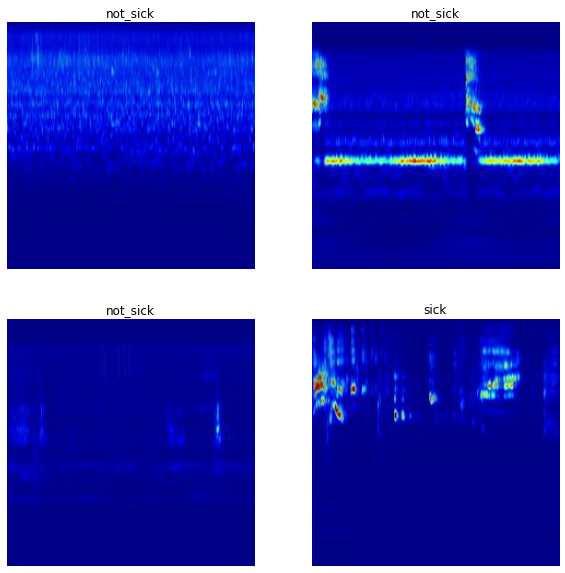

In [8]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow((image_batch[i].numpy()).astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# model

### Feature extraction

In [9]:
IMG_SHAPE = (img_height, img_width, 3)
# base_model = tf.keras.applications.DenseNet121(include_top=False, 
#                                                weights='imagenet', 
#                                                input_shape=IMG_SHAPE
# )
base_model = tf.keras.applications.ResNet50(include_top=False, 
                                            weights='imagenet', 
                                            input_shape=IMG_SHAPE,
                                            classes=1)
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 233, 233, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 114, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 227, 227, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 227, 227, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [11]:
base_learning_rate = 0.0001
save_dir = './fine_tune_resnet50_cwt/'
log_dir = save_dir + 'logs/'
checkpoint_dir = save_dir + 'checkpoint/'

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10),
        tf.keras.callbacks.TensorBoard(log_dir),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                            monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                            save_weights_only=True)
    ]

In [12]:
initial_epochs = 100

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/100
      1/Unknown - 5s 5s/step - loss: 0.8393 - accuracy: 0.2500WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.104376). Check your callbacks.
    929/Unknown - 26s 28ms/step - loss: 0.7050 - accuracy: 0.5996- 26s 28ms/step - loss: 0.7060 - accura
Epoch 00001: val_accuracy improved from -inf to 0.70714, saving model to ./fine_tune_resnet50_cwt/checkpoint/
929/929 [==============================] - 34s 37ms/step - loss: 0.7050 - accuracy: 0.5996 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
926/929 [============================>.] - ETA: 0s - loss: 0.6236 - accuracy: 0.6593
Epoch 00002: val_accuracy improved from 0.70714 to 0.72765, saving model to ./fine_tune_resnet50_cwt/checkpoint/
929/929 [==============================] - 29s 31ms/step - loss: 0.6241 - accuracy: 0.6588 - val_loss: 0.5205 - val_accuracy: 0.7276
Epoch 3/100
928/929 [============================>.] - ETA: 0s - loss: 0.5809 - accuracy: 0.6856
Epoch 00003:

Epoch 27/100
927/929 [============================>.] - ETA: 0s - loss: 0.4924 - accuracy: 0.7392
Epoch 00027: val_accuracy did not improve from 0.76784
929/929 [==============================] - 28s 30ms/step - loss: 0.4925 - accuracy: 0.7387 - val_loss: 0.4629 - val_accuracy: 0.7580
Epoch 28/100
927/929 [============================>.] - ETA: 0s - loss: 0.4898 - accuracy: 0.7487
Epoch 00028: val_accuracy did not improve from 0.76784
929/929 [==============================] - 28s 31ms/step - loss: 0.4907 - accuracy: 0.7489 - val_loss: 0.4632 - val_accuracy: 0.7662
Epoch 29/100
928/929 [============================>.] - ETA: 0s - loss: 0.4928 - accuracy: 0.7438
Epoch 00029: val_accuracy did not improve from 0.76784
929/929 [==============================] - 28s 30ms/step - loss: 0.4928 - accuracy: 0.7438 - val_loss: 0.4624 - val_accuracy: 0.7605
Epoch 30/100
927/929 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.7492
Epoch 00030: val_accuracy did not improve fr

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 10s 25ms/step - loss: 0.4675 - accuracy: 0.7676


[0.46747911432825623, 0.76755446]

### fine tuning

In [14]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False

model.summary()

Number of layers in the base model:  175
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 227, 227, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 227, 227, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)       

In [15]:
fine_tune_epochs = 100 + initial_epochs

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    base_learning_rate/10,
    decay_steps=steps_per_epoch*5,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = optimizer,
              metrics=['accuracy'])

history_fine = model.fit(train_ds,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=callbacks)

Epoch 35/200
    929/Unknown - 74s 79ms/step - loss: 0.4646 - accuracy: 0.7688
Epoch 00035: val_accuracy improved from 0.76784 to 0.82691, saving model to ./fine_tune_resnet50_cwt/checkpoint/
929/929 [==============================] - 83s 89ms/step - loss: 0.4646 - accuracy: 0.7688 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 36/200
928/929 [============================>.] - ETA: 0s - loss: 0.3476 - accuracy: 0.8386
Epoch 00036: val_accuracy improved from 0.82691 to 0.83183, saving model to ./fine_tune_resnet50_cwt/checkpoint/
929/929 [==============================] - 77s 83ms/step - loss: 0.3476 - accuracy: 0.8385 - val_loss: 0.3419 - val_accuracy: 0.8318
Epoch 37/200
928/929 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8815
Epoch 00037: val_accuracy improved from 0.83183 to 0.86218, saving model to ./fine_tune_resnet50_cwt/checkpoint/
929/929 [==============================] - 77s 83ms/step - loss: 0.2694 - accuracy: 0.8816 - val_loss: 0.3646 - 

928/929 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9997
Epoch 00062: val_accuracy did not improve from 0.87285
929/929 [==============================] - 76s 82ms/step - loss: 0.0101 - accuracy: 0.9997 - val_loss: 1.1707 - val_accuracy: 0.8704


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
model.load_weights(checkpoint_dir)
model.evaluate(test_ds)

413/413 [==============================] - 9s 22ms/step - loss: 1.1278 - accuracy: 0.8638


[1.1277785453332034, 0.8638015]